<a href="https://colab.research.google.com/github/Prim9000/Thai_TTS/blob/main/Thai_TTS_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extracting the Dataset

In [20]:
import os
import shutil
def download():
    url = "https://github.com/korakot/corpus/releases/download/v1.0/AIFORTHAI-TSync2Corpus.zip"
    print("NECTEC licensed TSync2 under CC-BY-NC-SA")
    print("Start downloading: .. ")
    os.system(f"wget {url}")
    os.system("unzip AIFORTHAI-TSync2Corpus.zip")
    os.system("rm AIFORTHAI-TSync2Corpus.zip")
    shutil.move('/content/TSync2/wav','/content/wav')
    shutil.move('/content/TSync2/wrd_ph','/content/wrd_ph')
    os.system("rm /content/TSync2")
    print("Finished")

In [ ]:
download()

In [ ]:
!unzip /content/drive/MyDrive/TSync2/TSync2.zip

# Trim silence sampling rate = 220505

In [ ]:
import matplotlib.pyplot as plt
import os
import librosa
import shutil
import soundfile as sf
from tqdm.auto import tqdm

In [ ]:
def trim(directory,filename,sr=22050, threshold=20):
  new_filename = "{}.wav".format(filename[:-4])
  signal, sr = librosa.load(os.path.join(directory,filename), sr=sr)
  trimed, index = librosa.effects.trim(signal, top_db=threshold)
  sf.write(os.path.join(directory, new_filename), trimed, samplerate=sr)
  shutil.move(os.path.join(directory, new_filename) , os.path.join('/content/wav', new_filename))

Trimming the silence (this would take a while)

In [ ]:
source = '/content/wav/'
for root, dirnames, filenames in os.walk(source):
    for filename in filenames:
      try:
        trim(source,filename)
      except:
        pass

# Tacotron2

In [ ]:
%cd /content/

In [ ]:
%tensorflow_version 1.x
import os
from os.path import exists, join, basename, splitext
git_repo_url = 'https://github.com/Prim9000/tacotron2.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # clone and install
  !git clone -q --recursive {git_repo_url}
  !cd {project_name}/waveglow && git checkout 9168aea
  !pip install -q librosa unidecode
  
import sys
sys.path.append(join(project_name, 'waveglow/'))
sys.path.append(project_name)
import time
import matplotlib
import matplotlib.pylab as plt
plt.rcParams["axes.grid"] = False

In [ ]:
def download_from_google_drive(file_id, file_name):
  # download a file from the Google Drive link
  !rm -f ./cookie
  !curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id={file_id}" > /dev/null
  confirm_text = !awk '/download/ {print $NF}' ./cookie
  confirm_text = confirm_text[0]
  !curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm={confirm_text}&id={file_id}" -o {file_name}

tacotron2_pretrained_model = 'tacotron2_statedict.pt'
if not exists(tacotron2_pretrained_model):
  # download the Tacotron2 pretrained model
  download_from_google_drive('1c5ZTuT7J08wLUoVZ2KkUs_VdZuJ86ZqA', tacotron2_pretrained_model)
waveglow_pretrained_model = 'waveglow_old.pt'
if not exists(waveglow_pretrained_model):
  # download the Waveglow pretrained model  
  download_from_google_drive('1WsibBTsuRg_SF2Z6L6NFRTT-NjEy1oTx', waveglow_pretrained_model)

In [ ]:
import IPython.display as ipd
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT
from audio_processing import griffin_lim
from text import text_to_sequence
from denoiser import Denoiser

def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none', cmap='viridis')

torch.set_grad_enabled(False)
        
# initialize Tacotron2 with the pretrained model
hparams = create_hparams()
hparams.sampling_rate = 22050
model = Tacotron2(hparams)
model.load_state_dict(torch.load(tacotron2_pretrained_model)['state_dict'])
_ = model.cuda().eval()#.half()

# initialize Waveglow with the pretrained model
# waveglow = torch.load(waveglow_pretrained_model)['model']
# WORKAROUND for: https://github.com/NVIDIA/tacotron2/issues/182
import json
from glow import WaveGlow
waveglow_config = json.load(open('%s/waveglow/config.json' % project_name))['waveglow_config']
waveglow = WaveGlow(**waveglow_config)
waveglow.load_state_dict(torch.load(waveglow_pretrained_model)['model'].state_dict())
_ = waveglow.cuda().eval()#.half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

In [ ]:
%cd /content/tacotron2

In [ ]:
shutil.move('/content/tacotron2_statedict.pt','/content/tacotron2/tacotron2_statedict.pt')

In [ ]:
from scipy.io import wavfile
samplerate, data = wavfile.read('/content/wav/tsync2_noon_0_1228.wav')

# Training

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir=outdir/logdir

In [ ]:
!gdown --id 1tukxLX1Ul2O3zpTztX18K6WWfMrPiXJ2

In [ ]:
# Training from the beginning
#!python train.py --output_directory=outdir --log_directory=logdir -c tacotron2_statedict.pt --warm_start

In [ ]:
# Training from scratch (cold start)
#!python train.py --output_directory=outdir --log_directory=logdir

In [ ]:
download_from_google_drive('1tukxLX1Ul2O3zpTztX18K6WWfMrPiXJ2', v tacotron2_pretrained_model)

In [21]:
!python train.py --output_directory=outdir --log_directory=logdir -c /content/tacotron2/checkpoint_10000 --warm_start

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

FP16 Run: False
Dynamic Loss Scaling: True
Distributed Run: False
cuDNN Enabled: True
cuDNN Benchmark: False
Warm starting model from checkpoint '/content/tacotron2/checkpoint_10000'
Epoch: 0
Train loss 0 0.300531 Grad Norm 0.715434 2.13s/it
Validation loss 0:  0.724028  
Saving model and optimizer state at iteration 0 to outdir/checkpoint_0
Train loss 1 0.538665 Grad Norm 10.023797 1.95s/it
Train loss 2 0.412394 Grad Norm 2.197048 1.81s/it
Train loss 3 0.483536 Grad Norm 6.272793 1.88s/it
Train loss 4 0.351286 Grad Norm 2.446315 1.69s/it
Train loss 5 0.403424 Grad Norm 3.555284 2.00s/it
Train loss 6 0.374387 Grad Norm 3.732428 

# Synthesizing Speech

In [22]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from denoiser import Denoiser

In [23]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

In [24]:
hparams = create_hparams()
hparams.sampling_rate = 22050

### Change your checkpoint

In [37]:
#change your checkpoint path here
checkpoint_path ='/content/tacotron2/checkpoint_10000' # '/content/tacotron2/outdir/checkpoint_0'
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

In [26]:
waveglow_path = '/content/waveglow_old.pt'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retrieve the original source code by accessing the object's source attribute or

In [27]:
!pip install pythainlp

## Change your text

In [38]:
text = 'ยินดีที่ได้รู้จัก นี่คือเสียงจากปัญญาประดิษฐ์'

In [39]:
from pythainlp import word_tokenize
def text_process(text):
    final = text
    final = word_tokenize(final)
    final = " ".join(word for word in final)
    final += " ."
    return final
text = text_process(text)

In [40]:
text

'ยินดี ที่ ได้ รู้จัก   นี่ คือ เสียง จาก ปัญญาประดิษฐ์ .'

In [41]:
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

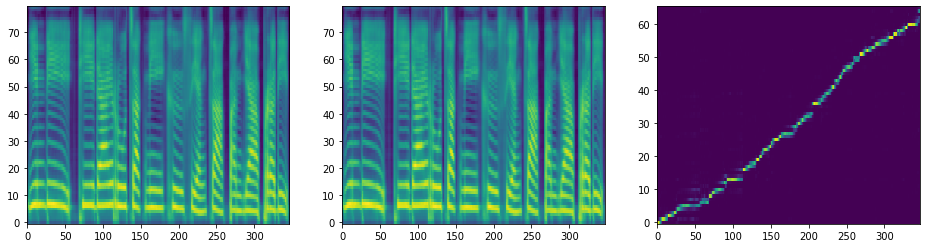

In [42]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
%matplotlib inline
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

## The Synthesized Speech

In [43]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

Add Denoiser

In [44]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate)